# Neural Computing Coursework - Testing Notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as ss
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
import torch.nn.functional as F
device = 'cpu'
import math
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import torch.optim as optim
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from joblib import dump, load
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

Preprocessing

In [2]:
data = pd.read_csv('dermatology.csv')
data.columns = data.columns.str.lstrip()
data = data.replace('?',np.nan )
data['Age'] = pd.to_numeric(data['Age'])
mean_age = data['Age'].mean()
data['Age'] = data['Age'].replace(np.nan, mean_age)

data_vars = data.iloc[:,:-1]
data_labels = data.iloc[:, -1].values
data_labels = data_labels - 1

data_vars = data_vars.astype(np.float32)
data_vars = data_vars.to_numpy()
data_labels = data_labels.astype(np.int64)

In [3]:
x_train, x_test, y_train, y_test = train_test_split(data_vars, data_labels, test_size = 0.25, train_size = 0.75, random_state = 42)

scaler = StandardScaler()
scaler.fit(data_vars)
data_scale_fit = scaler.transform(data_vars)
data_x_smote_scale_fit, data_y_smote_scale_fit = SMOTE().fit_resample(data_scale_fit, data_labels)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_smote_sampled, y_smote_sampled = SMOTE().fit_resample(x_train_scaled, y_train)

## MLP Model

In [4]:
input_layer_dim=34
hidden_layer_dim=10
output_layer_dim=6

In [5]:
class TunedClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=input_layer_dim,
            hidden_dim=hidden_layer_dim,
            output_dim=output_layer_dim,
            dropout=0.5,
    ):
        super(TunedClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

Load the MLP model

In [6]:
mlp = load('derm_MLP_tuned_model.joblib') 

In [7]:
mlp.fit(x_smote_sampled, y_smote_sampled)

Re-initializing module because the following parameters were re-set: dropout.
Re-initializing optimizer because the following parameters were re-set: momentum, weight_decay.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7898       0.3191        1.7582  0.2421
      2        1.7296       0.5532        1.6167  0.0100
      3        1.5388       0.7128        1.4150  0.0090
      4        1.3840       0.7872        1.3100  0.0070
      5        1.2870       0.9574        1.1966  0.0110
      6        1.1655       0.9468        1.1174  0.0110
      7        1.0963       0.9574        1.0947  0.0080
      8        1.0689       0.9787        1.0803  0.0120
      9        1.0618       0.9574        1.0797  0.0100
     10        1.0575       0.9681        1.0814  0.0100
     11        1.0562       0.9681        1.0803  0.0080
     12        1.0552       0.9681        1.0790  0.0100
     13        1.0547       

C:\Users\nairx108\anaconda3\lib\site-packages\torch\autograd\__init__.py:145: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(


     17        1.0531       0.9681        1.0773  0.0170
     18        1.0528       0.9681        1.0771  0.0110
     19        1.0525       0.9681        1.0770  0.0120
     20        1.0523       0.9681        1.0768  0.0120
     21        1.0520       0.9681        1.0767  0.0120
     22        1.0518       0.9681        1.0766  0.0080
     23        1.0516       0.9681        1.0765  0.0100
     24        1.0514       0.9681        1.0764  0.0120
     25        1.0513       0.9681        1.0764  0.0100
     26        1.0511       0.9681        1.0764  0.0100
     27        1.0510       0.9681        1.0764  0.0090
     28        1.0509       0.9681        1.0763  0.0110
     29        1.0508       0.9681        1.0762  0.0090
     30        1.0507       0.9681        1.0761  0.0080
     31        1.0506       0.9681        1.0761  0.0110
     32        1.0505       0.9681        1.0759  0.0110


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=TunedClassifierModule(
    (dropout): Dropout(p=0, inplace=False)
    (hidden): Linear(in_features=34, out_features=10, bias=True)
    (output): Linear(in_features=10, out_features=6, bias=True)
  ),
)

Evaluate model on test set

In [8]:
y_pred = mlp.predict(x_test_scaled)

accuracy_score(y_test, y_pred)

0.9782608695652174

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       0.86      1.00      0.92        12
           2       1.00      1.00      1.00        17
           3       1.00      0.82      0.90        11
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00         4

    accuracy                           0.98        92
   macro avg       0.98      0.97      0.97        92
weighted avg       0.98      0.98      0.98        92



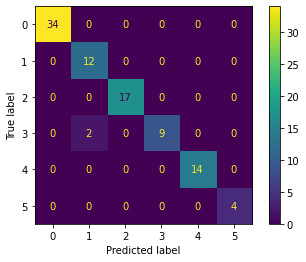

In [10]:
plot_labels = [0, 1, 2, 3, 4, 5]
cm = confusion_matrix(y_test, y_pred, labels=plot_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=plot_labels)
disp.plot() 

## SVM Model

In [11]:
svc = load('derm_SVC_tuned_model.joblib') 

In [12]:
svc.fit(x_smote_sampled, y_smote_sampled)

SVC(C=100, gamma=0.01, kernel='linear', random_state=0)

In [13]:
y_pred = svc.predict(x_test_scaled)

accuracy_score(y_test, y_pred)

0.9891304347826086

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       0.92      1.00      0.96        12
           2       1.00      1.00      1.00        17
           3       1.00      0.91      0.95        11
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00         4

    accuracy                           0.99        92
   macro avg       0.99      0.98      0.99        92
weighted avg       0.99      0.99      0.99        92



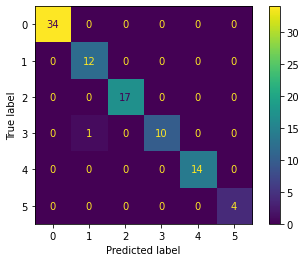

In [15]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=plot_labels)
disp.plot() 

## Cross Validation for MLP and SVC

MLP

In [16]:
mlp_scores = cross_validate(mlp, data_x_smote_scale_fit, data_y_smote_scale_fit, scoring='accuracy', cv=10)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7857       0.4628        1.7246  0.0100
      2        1.6495       0.8347        1.4139  0.0120
      3        1.3279       0.9339        1.2242  0.0110
      4        1.2218       0.8760        1.1672  0.0130
      5        1.1919       0.9669        1.0852  0.0120
      6        1.0724       0.9669        1.0778  0.0130
      7        1.0603       0.9669        1.0800  0.0110
      8        1.0567       0.9669        1.0795  0.0100
      9        1.0551       0.9587        1.0787  0.0110
     10        1.0546       0.9587        1.0780  0.0130
     11        1.0542       0.9587        1.0774  0.0120
     12        1.0538       0.9587        1.0770  0.0140
     13        1.0534       0.9587        1.0767  0.0130
     14        1.0529       0.9587        1.0769  0.0120
     15        1.0520       0.9587        1.0777  0.0120
     16        1.0505       0.9

In [17]:
print("Test Score after 10 fold k validation: {:.3f}%".format(mlp_scores['test_score'].mean()*100))

Test Score after 10 fold k validation: 98.218%


SVC

In [18]:
svc_scores = cross_validate(svc, data_x_smote_scale_fit, data_y_smote_scale_fit, scoring='accuracy', cv=10)

In [19]:
print("Test Score after 10 fold k validation: {:.3f}%".format(svc_scores['test_score'].mean()*100))

Test Score after 10 fold k validation: 99.405%
